In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
import datetime as dt
import seaborn as sns
sns.set_style("whitegrid")

In [2]:
path = '../Data/df.csv'

In [3]:
# read data csv
df1= pd.read_csv(path, parse_dates=['Date'])
df1 = df1.rename(columns = {"Date":"ds","Close":"y"}) 
df1 

,ds,y,tby,ffr,fta,eps,div,une,wti,ppi,rfs
0,2003-01-02,909.03,4.07,1.24,732202.0,40.40,1.79,5.8,31.97,135.3,295248.0
1,2003-01-03,908.59,4.05,1.24,732202.0,40.40,1.79,5.8,33.26,135.3,295248.0
2,2003-01-06,929.01,4.09,1.24,732202.0,40.40,1.79,5.8,32.29,135.3,295248.0
3,2003-01-07,922.93,4.04,1.24,732202.0,40.40,1.79,5.8,31.20,135.3,295248.0
4,2003-01-08,909.93,4.00,1.24,724902.0,40.40,1.79,5.8,30.66,135.3,295248.0
...,...,...,...,...,...,...,...,...,...,...,...
4515,2021-01-25,3855.36,1.05,0.09,7414942.0,95.72,1.58,6.3,52.78,204.3,576466.0
4516,2021-01-26,3849.62,1.05,0.09,7414942.0,95.72,1.58,6.3,52.61,204.3,576466.0
4517,2021-01-27,3750.77,1.04,0.09,7404926.0,95.72,1.58,6.3,52.81,204.3,576466.0
4518,2021-01-28,3787.38,1.07,0.09,7404926.0,95.72,1.58,6.3,52.26,204.3,576466.0


In [7]:
import datetime as datetime
# use data before covid time
ctf_date = datetime.datetime(2020, 3, 1)
df = df1.loc[df1.ds < ctf_date , ].copy()
df

,ds,y,tby,ffr,fta,eps,div,une,wti,ppi,rfs
0,2003-01-02,909.03,4.07,1.24,732202.0,40.40,1.79,5.8,31.97,135.3,295248.0
1,2003-01-03,908.59,4.05,1.24,732202.0,40.40,1.79,5.8,33.26,135.3,295248.0
2,2003-01-06,929.01,4.09,1.24,732202.0,40.40,1.79,5.8,32.29,135.3,295248.0
3,2003-01-07,922.93,4.04,1.24,732202.0,40.40,1.79,5.8,31.20,135.3,295248.0
4,2003-01-08,909.93,4.00,1.24,724902.0,40.40,1.79,5.8,30.66,135.3,295248.0
...,...,...,...,...,...,...,...,...,...,...,...
4285,2020-02-24,3225.89,1.38,1.58,4171570.0,135.28,1.79,3.5,51.36,196.7,525810.0
4286,2020-02-25,3128.21,1.33,1.58,4171570.0,135.28,1.79,3.5,49.78,196.7,525810.0
4287,2020-02-26,3116.39,1.33,1.58,4158637.0,135.28,1.79,3.5,48.67,196.7,525810.0
4288,2020-02-27,2978.76,1.30,1.58,4158637.0,135.28,1.79,3.5,47.17,196.7,525810.0


In [9]:
# test data: predict 1 year (~252 trading days)
pred_periods = 252
p = 0.9
# temporary predicted periods on trainining data
tmp_pred_periods= 100

In [10]:
# number of windows (iterrations)
num_winds = int(pred_periods * (p*10)//100 + 1)

# initial data on training data
start = len(df) - num_winds *tmp_pred_periods - pred_periods

# cutoff between test data and train data
cutoff = start + num_winds * tmp_pred_periods

print(num_winds, cutoff, cutoff-start )

23 4038 2300


In [11]:
df_train = df[:cutoff].copy()
df_test = df.drop(df_train.index).copy()

In [12]:
#prophet part 
from fbprophet import Prophet
pro_pred = []

# use accumulated data to predict the next pred_size data
for i in range(num_winds):
    end = start+ i*tmp_pred_periods
    
    tmp_train = df_train.iloc[: end].copy()
    
    fbp = Prophet(daily_seasonality=True) 
    # fit close price using fbprophet model
    fbp.fit(tmp_train[['ds','y']])
    
    # predict pred_size futures and get the forecast price 
    fut = fbp.make_future_dataframe(periods = tmp_pred_periods)
    tmp_forecast = fbp.predict(fut) 
    if (i == 0):
        pro_pred.append(tmp_forecast[:start].yhat)
      
    # only require the forcast on test data of temporary training data
    pred = tmp_forecast[end:].yhat
    pro_pred.append(pred)

In [13]:
# pro_pred

In [15]:
# flat the pro_pred
flat_pro_pred = [item for l1 in pro_pred for item in l1]

In [16]:
df_train['fbsp'] = pd.Series(flat_pro_pred)

In [17]:
from fbprophet import Prophet
fbp = Prophet(daily_seasonality=True)

# fit close price using fbprophet model
fbp.fit(df_train[['ds','y']])
    
 # predict pred_size futures and get the forecast price 
fut = fbp.make_future_dataframe(periods = pred_periods, freq='D')
forecast = fbp.predict(fut) 

In [18]:
df_test['fbsp'] = forecast.loc[cutoff:, 'yhat']
df_test

,ds,y,tby,ffr,fta,eps,div,une,wti,ppi,rfs,fbsp
4038,2019-02-27,2792.38,2.69,2.40,3974590.0,140.02,2.08,3.8,56.92,199.2,502627.0,2897.809968
4039,2019-02-28,2784.49,2.73,2.40,3974590.0,140.12,1.98,3.8,57.21,199.2,502627.0,2898.887506
4040,2019-03-01,2803.69,2.76,2.41,3974590.0,140.12,1.98,3.8,55.76,200.8,510320.0,2899.165358
4041,2019-03-04,2792.81,2.72,2.41,3974590.0,140.12,1.98,3.8,56.60,200.8,510320.0,2908.581350
4042,2019-03-05,2789.65,2.72,2.41,3974590.0,140.12,1.98,3.8,56.55,200.8,510320.0,2909.311727
...,...,...,...,...,...,...,...,...,...,...,...,...
4285,2020-02-24,3225.89,1.38,1.58,4171570.0,135.28,1.79,3.5,51.36,196.7,525810.0,3075.385803
4286,2020-02-25,3128.21,1.33,1.58,4171570.0,135.28,1.79,3.5,49.78,196.7,525810.0,3085.118778
4287,2020-02-26,3116.39,1.33,1.58,4158637.0,135.28,1.79,3.5,48.67,196.7,525810.0,3086.077178
4288,2020-02-27,2978.76,1.30,1.58,4158637.0,135.28,1.79,3.5,47.17,196.7,525810.0,3077.225606


In [19]:
fc_df = pd.DataFrame(data={'ds': df.ds.to_numpy().ravel(), 'fbsp': forecast.yhat})
# fc_df

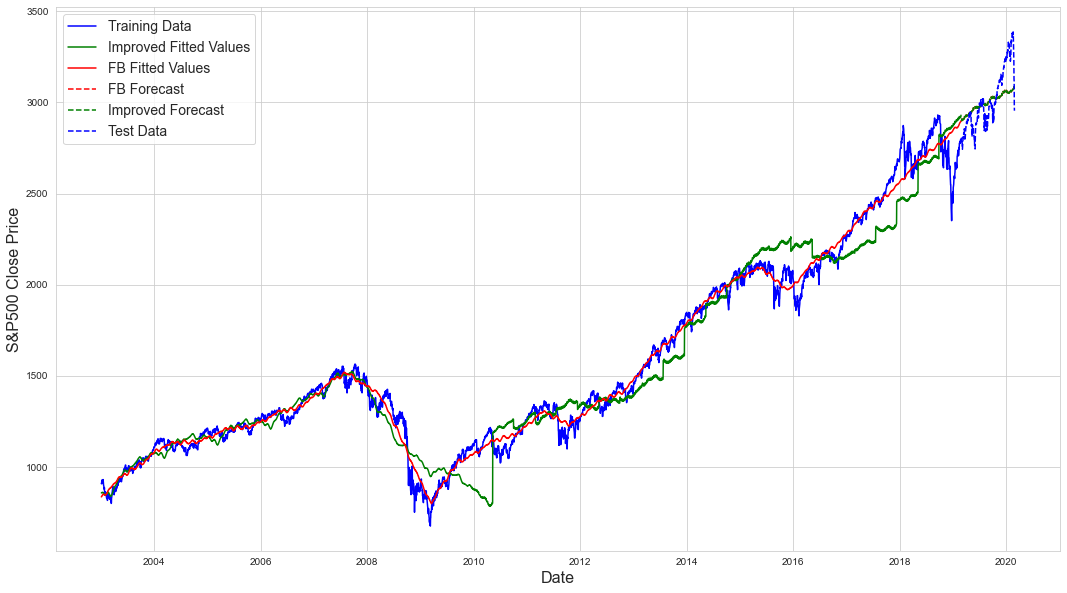

In [20]:
plt.figure(figsize=(18,10))

# plot the training data
plt.plot(df_train.ds,df_train.y,'b', label = "Training Data")

plt.plot(df_train.ds,df_train.fbsp,'g-', label = "Improved Fitted Values")

# plot the fit
plt.plot(df_train.ds, fc_df[:cutoff].fbsp,'r-', label = "FB Fitted Values")

# plot the forecast
plt.plot(df_test.ds, fc_df[cutoff:].fbsp,'r--', label = "FB Forecast")
plt.plot(df_test.ds,  df_test.fbsp,'g--',label = "Improved Forecast")
plt.plot(df_test.ds, df_test.y,'b--', label = "Test Data")

plt.legend(fontsize=14)

plt.xlabel("Date", fontsize=16)
plt.ylabel("S&P500 Close Price", fontsize=16)

plt.show()

In [21]:
df2 = df.copy()
df2['fbsp'] = pd.concat([df_train,df_test]).fbsp
df2['diff'] = df2['y'] - df2['fbsp']

In [22]:
df2 = df2.dropna()
df2['ds'] = pd.to_datetime(df2['ds'])
df2 = df2.set_index(df2['ds'])
df2 = df2.drop(columns=['ds'])

In [23]:
df3 = df2.loc[df2.index[start]:,].copy()
df3

,y,tby,ffr,fta,eps,div,une,wti,ppi,rfs,fbsp,diff
ds,,,,,,,,,,,,
2009-12-15,1107.93,3.60,0.12,2186762.0,46.72,2.10,9.9,70.62,178.1,346072.0,890.492142,217.437858
2009-12-16,1109.18,3.61,0.12,2236035.0,46.72,2.10,9.9,72.64,178.1,346072.0,888.058929,221.121071
2009-12-17,1096.08,3.50,0.12,2236035.0,46.72,2.10,9.9,72.58,178.1,346072.0,887.896209,208.183791
2009-12-18,1102.47,3.55,0.12,2236035.0,46.72,2.10,9.9,73.30,178.1,346072.0,885.258538,217.211462
2009-12-21,1114.05,3.69,0.12,2236035.0,46.72,2.10,9.9,72.71,178.1,346072.0,889.359069,224.690931
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-02-24,3225.89,1.38,1.58,4171570.0,135.28,1.79,3.5,51.36,196.7,525810.0,3075.385803,150.504197
2020-02-25,3128.21,1.33,1.58,4171570.0,135.28,1.79,3.5,49.78,196.7,525810.0,3085.118778,43.091222
2020-02-26,3116.39,1.33,1.58,4158637.0,135.28,1.79,3.5,48.67,196.7,525810.0,3086.077178,30.312822


In [24]:
df3.to_csv(r'../Data/dff1.csv')